In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import brier_score, concordance_index_censored, cumulative_dynamic_auc
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
import matplotlib.pyplot as plt
from sksurv.util import Surv
from lifelines.fitters.kaplan_meier_fitter import KaplanMeierFitter
from sksurv.nonparametric import kaplan_meier_estimator
from scipy.stats import norm
import seaborn as sns

In [2]:
X_TRAIN = []
X_TEST = []
Y_TRAIN1 = []
Y_TEST1 = []
Y_TRAIN = []
Y_TEST = []

In [3]:
IND_TRAIN = [[4,5,6,7,8,9,10,11,12,13,14,15, 16,17,18,19], 
             [0,1,2,3,8,9,10,11,12,13,14,15, 16,17,18,19], 
             [0,1,2,3,4,5,6,7,12,13,14,15, 16,17,18,19], 
             [0,1,2,3,4,5,6,7,8,9,10,11,16,17,18,19],
             [0,1,2,3,4,5,6,7,8,9,10,11, 12,13,14,15]]
IND_TEST = [[0,1,2,3], [4,5,6,7], [8,9,10,11], [12,13,14,15],[16,17,18,19]]
for i in range(5):
    ind_train = IND_TRAIN[i]
    ind_test = IND_TEST[i]

    data_train = []
    for j in ind_train:
        dat = pd.read_csv(f'C:/Users/ndong/OneDrive - Texas Tech University/Documents/Scalable Survival-DP Package/Simulation/Original Copy of Simulation/Simulation 3 - small std/simulated data 3_{j+1}.csv', index_col=0)
        data_train.append(dat)
    
    data_test=[]
    for j in ind_test:
        dat = pd.read_csv(f'C:/Users/ndong/OneDrive - Texas Tech University/Documents/Scalable Survival-DP Package/Simulation/Original Copy of Simulation/Simulation 3 - small std/simulated data 3_{j+1}.csv', index_col=0)
        data_test.append(dat)

    Train = pd.concat(data_train, ignore_index=True)
    Test = pd.concat(data_test, ignore_index=True)
    y_train = Train[['Y', 'c_y']]
    y_train['Y'] = np.exp(y_train['Y'])
    y_test = Test[['Y', 'c_y']]
    y_test['Y'] = np.exp(y_test['Y'])
    y_train.columns = ['time_to_event', 'event']
    y_test.columns = ['time_to_event', 'event']
    Testing1 = Test.drop(columns=['z_x', 'z_y', 'c_y', 'y_mu', 'y_sigma', 'Y'])
    X_name = Testing1.columns
    X_train = Train[X_name]
    X_test = Test[X_name]
    y_train1 = Surv.from_arrays(y_train['event'], y_train['time_to_event'])
    y_test1 = Surv.from_arrays(y_test['event'], y_test['time_to_event'])
    X_TRAIN.append(X_train)
    X_TEST.append(X_test)
    Y_TRAIN1.append(y_train1)
    Y_TEST1.append(y_test1)
    Y_TRAIN.append(y_train)
    Y_TEST.append(y_test)

C:\Users\ndong\AppData\Local\Temp\ipykernel_23672\3343784147.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['Y'] = np.exp(y_train['Y'])
C:\Users\ndong\AppData\Local\Temp\ipykernel_23672\3343784147.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Y'] = np.exp(y_test['Y'])
C:\Users\ndong\AppData\Local\Temp\ipykernel_23672\3343784147.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [4]:
SCORE = []
C_INDEX = []
pred_cox = []
for j in range(5):
    Cph = CoxPHSurvivalAnalysis()
    est_cox = Cph.fit(X_TRAIN[j], Y_TRAIN1[j])
    survs_test = est_cox.predict_survival_function(X_TEST[j])
    pred_cox.append(survs_test)
    survs_train = est_cox.predict_survival_function(X_TRAIN[j])
    pred_train = est_cox.predict(X_TRAIN[j])
    pred_test = est_cox.predict(X_TEST[j])
    cumu_h_train = est_cox.predict_cumulative_hazard_function(X_TRAIN[j], return_array=True)
    cumu_h_test = est_cox.predict_cumulative_hazard_function(X_TEST[j], return_array=True)
    XX = est_cox.unique_times_
    rec = []

    for i in [1, 3, 5, 7, 9]:
        preds_test = np.array([fn(365*i) for fn in survs_test])
        preds_test[preds_test == np.inf] = 0
        preds_train = np.array([fn(365*i) for fn in survs_train])
        preds_train[preds_train == np.inf] = 0
        auroc_train = cumulative_dynamic_auc(Y_TRAIN1[j], Y_TRAIN1[j], pred_train, i*365)
        auroc_test = cumulative_dynamic_auc(Y_TRAIN1[j], Y_TEST1[j], pred_test, i*365)
    #    times, score = brier_score(y_train1, y_test1, preds_test, 365*i)
        y_train_true = Y_TRAIN[j]
        y_train_true['score'] = preds_train
        y_test_true = Y_TEST[j]
        y_test_true['score'] = preds_test
        y_true_train = y_train_true[((y_train_true['time_to_event'] <= i*365) & (y_train_true['event'] == 1))|(y_train_true['event'] == 0) & (y_train_true['time_to_event'] >= i*365)]
        y_true_test = y_test_true[
            ((y_test_true['time_to_event'] <= i * 365) & (y_test_true['event'] == 1)) | (y_test_true['event'] == 0) & (
                        y_test_true['time_to_event'] >= i * 365)]
        precision_train, recall_train, thresholds_train = metrics.precision_recall_curve(y_true_train['event'], y_true_train['score'])
        precision_test, recall_test, thresholds_test = metrics.precision_recall_curve(y_true_test['event'],
                                                                                        y_true_test['score'])
        prc_train = pd.DataFrame({'precision_train': precision_train, 'recall_train': recall_train})
        prc_test = pd.DataFrame({'precision_test': precision_test, 'recall_test': recall_test})
        prc_train.sort_values(by='precision_train', inplace=True)
        prc_test.sort_values(by='precision_test', inplace=True)
        auprc_train = metrics.auc(recall_train, precision_train)
        auprc_test = metrics.auc(recall_test, precision_test)
        # y_train_true = (y_train['time_to_event'] > 365*i)
        # y_test_true = (y_test['time_to_event'] > 365*i)
        # fprtrain, tprtrain, threstrain = metrics.roc_curve(y_train_true, preds_train)
        # fprtest, tprtest, threstest = metrics.roc_curve(y_test_true, preds_test)
        # auroc_train = metrics.auc(fprtrain, tprtrain)
        # auroc_test = metrics.auc(fprtest, tprtest)
        # f1_train = metrics.f1_score(y_train_true, preds_train)
        # f1_test = metrics.f1_score(y_test_true, preds_test)
        rec.append([i, auroc_train[0], auroc_test[0], auprc_train, auprc_test])
    brier = pd.DataFrame(rec, columns=['year', 'auroc_train', 'auroc_test', 'auprc_train', 'auprc_test'])
    print('Brier Score: \n', brier)
    C_index_test = est_cox.score(X_TEST[j], Y_TEST1[j])
    C_index_train = est_cox.score(X_TRAIN[j], Y_TRAIN1[j])
    print('Concordance Index:', C_index_train, C_index_test)
    SCORE.append(brier.values)
    C_INDEX.append([C_index_train, C_index_test])

C:\Users\ndong\AppData\Local\Temp\ipykernel_23672\3511529601.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_true['score'] = preds_train
C:\Users\ndong\AppData\Local\Temp\ipykernel_23672\3511529601.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_true['score'] = preds_test
C:\Users\ndong\AppData\Local\Temp\ipykernel_23672\3511529601.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

Brier Score: 
    year           auroc_train            auroc_test  auprc_train  auprc_test
0     1   [0.994874019266718]   [0.994525261370605]     0.246007    0.245640
1     3   [0.751260321576517]  [0.7341367678663488]     0.702371    0.699325
2     5  [0.7102469945815174]  [0.6741144096195816]     0.942588    0.944029
3     7  [0.7263355372793007]  [0.6748768777263213]     0.979975    0.975816
4     9  [0.6978967907058549]  [0.6396720290264595]     0.994061    0.991395
Concordance Index: 0.7412314091890484 0.7246377976884448


In [5]:
pd.DataFrame(np.array(SCORE).mean(axis=0), columns=['year', 'auroc_train', 'auroc_test', 'auprc_train', 'auprc_test'])

,year,auroc_train,auroc_test,auprc_train,auprc_test
0,1.0,[0.9947104981760779],[0.9945359522337766],0.245941,0.245956
1,3.0,[0.7486773432356412],[0.7447104833353106],0.701123,0.704561
2,5.0,[0.7037856142561342],[0.6993673714599471],0.942623,0.943454
3,7.0,[0.716915842201155],[0.7104568649530726],0.978863,0.979402
4,9.0,[0.6871797306960732],[0.6759898972215803],0.993382,0.993538


In [6]:
pd.DataFrame(np.array(C_INDEX).mean(axis=0).reshape(1,-1), columns=['CI-train', 'CI-test'])

,CI-train,CI-test
0,0.738203,0.736102


In [7]:
## True Survival prob:

DDDD = []
for i in range(20):
    dat = pd.read_csv(f'C:/Users/ndong/OneDrive - Texas Tech University/Documents/Scalable Survival-DP Package/Simulation/Original Copy of Simulation/Simulation 3 - small std - 2000/Simulated data 3_{i+1}.csv', index_col=0)
    DDDD.append(dat)
FULL = pd.concat(DDDD, ignore_index=True)
YY = FULL['Y'].values
True_mean_y = FULL['y_mu'].values
True_sigma_y = np.sqrt(FULL['y_sigma'])
True_z_y = FULL['z_y']
True_surv = norm.sf(YY, scale=True_sigma_y, loc=True_mean_y)
DDelta = FULL['c_y']
YY = np.exp(YY)

,time_to_event,event,score
0,883.266920,1.0,0.008984
1,1211.139233,1.0,0.014344
2,957.274326,1.0,0.011727
3,1258.493442,1.0,0.009849
4,1037.378631,1.0,0.008960
...,...,...,...
9995,0.017839,0.0,0.016615
9996,0.746847,0.0,0.022568
9997,0.141935,0.0,0.021446
9998,1.504454,0.0,0.021947


In [ ]:
YY

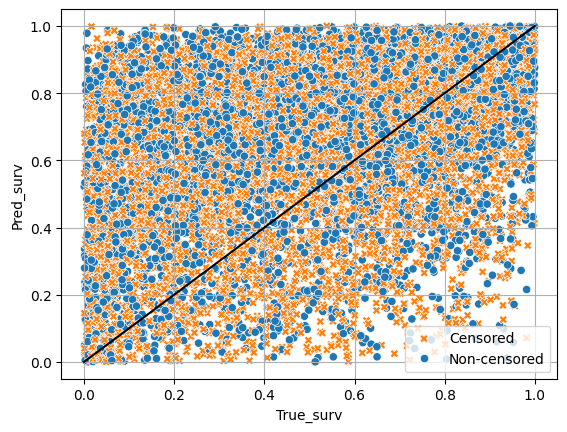

In [18]:
surv_cox = np.concatenate(pred_cox).T
preds_surv_cox = []
for i in range(10000):
    upp = max(surv_cox[i].x)
    if YY[i] <= upp:
        ss = surv_cox[i](YY[i])
    else:
        ss = (surv_cox[i].y)[-1]
    preds_surv_cox.append(ss)
surv_cox = np.array(preds_surv_cox)
# surv_cox = np.array([print(surv_cox[i], YY[i], i) for i in range(3382)])
SURV_cox = pd.DataFrame({'True_surv': True_surv, 'Pred_surv': surv_cox, 'z_y': True_z_y, 'c_y': DDelta})
error = abs(SURV_cox['True_surv'] - SURV_cox['Pred_surv'])
MSE = np.median(round(error, 4))
R_sq = 1 - (sum(error**2)/sum((SURV_cox['True_surv'] - SURV_cox['True_surv'].mean()) ** 2))
R_sq = round(R_sq, 4)
R_sq

sns.scatterplot(SURV_cox, x='True_surv', y='Pred_surv', hue='c_y', style='c_y')
sns.lineplot(x=[0,1], y=[0,1], color='black')
plt.legend(['Censored', 'Non-censored'])
plt.grid()
plt.show()

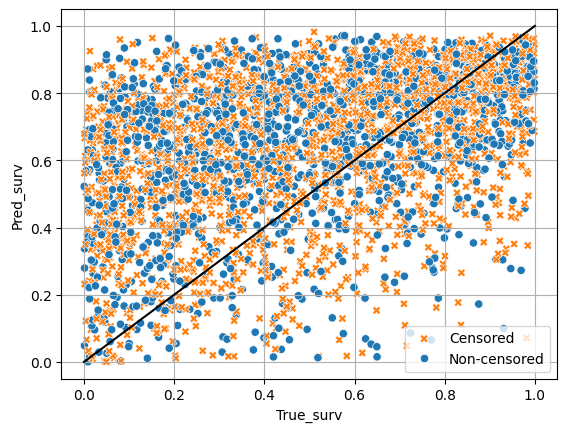

np.float64(0.21055000000000001)

In [10]:
sns.scatterplot(SURV_cox[SURV_cox['z_y'] == 1], x='True_surv', y='Pred_surv', hue='c_y', style='c_y')
sns.lineplot(x=[0,1], y=[0,1], color='black')
plt.legend(['Censored', 'Non-censored'])
plt.grid()
error = abs(SURV_cox[SURV_cox['z_y'] == 1]['True_surv'] - SURV_cox[SURV_cox['z_y'] == 1]['Pred_surv'])
MSE = np.median(round(error, 4))
plt.show()
MSE

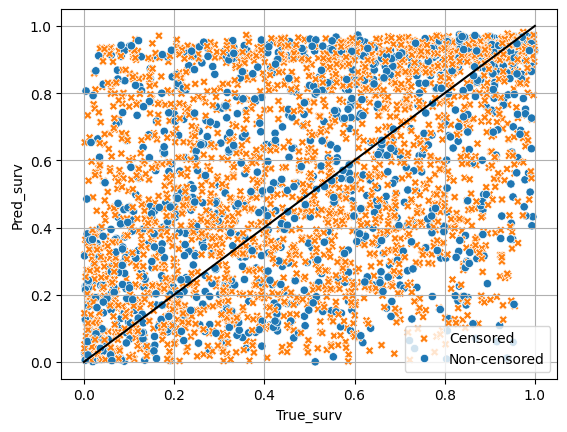

0.208

In [ ]:
sns.scatterplot(SURV_cox[SURV_cox['z_y'] == 2], x='True_surv', y='Pred_surv', hue='c_y', style='c_y')
sns.lineplot(x=[0,1], y=[0,1], color='black')
plt.legend(['Censored', 'Non-censored'])
plt.grid()
error = abs(SURV_cox[SURV_cox['z_y'] == 2]['True_surv'] - SURV_cox[SURV_cox['z_y'] == 2]['Pred_surv'])
MSE = np.median(round(error, 4))
plt.show()
MSE

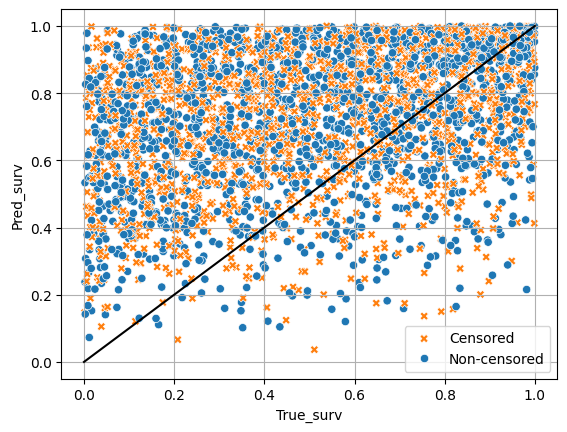

0.266

In [ ]:
sns.scatterplot(SURV_cox[SURV_cox['z_y'] == 3], x='True_surv', y='Pred_surv', hue='c_y', style='c_y')
sns.lineplot(x=[0,1], y=[0,1], color='black')
plt.legend(['Censored', 'Non-censored'])
plt.grid()
error = abs(SURV_cox[SURV_cox['z_y'] == 3]['True_surv'] - SURV_cox[SURV_cox['z_y'] == 3]['Pred_surv'])
MSE = np.median(round(error, 4))
plt.show()
MSE

In [ ]:
# data_train = []
# ind_train = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
# ind_test = [16,17,18,19]
# for i in ind_train:
#     dat = pd.read_csv(f'C:/Users/ndong/OneDrive - Texas Tech University/Documents/Scalable Survival-DP Package/Simulation/Original Copy of Simulation/Simulation 3 - small std/simulated data 3_{i+1}.csv', index_col=0)
#     data_train.append(dat)

# data_test=[]
# for i in ind_test:
#     dat = pd.read_csv(f'C:/Users/ndong/OneDrive - Texas Tech University/Documents/Scalable Survival-DP Package/Simulation/Original Copy of Simulation/Simulation 3 - small std/simulated data 3_{i+1}.csv', index_col=0)
#     data_test.append(dat)

# Train = pd.concat(data_train, ignore_index=True)
# Test = pd.concat(data_test, ignore_index=True)
# y_train = Train[['Y', 'c_y']]
# y_train['Y'] = np.exp(y_train['Y'])
# y_test = Test[['Y', 'c_y']]
# y_test['Y'] = np.exp(y_test['Y'])
# y_train.columns = ['time_to_event', 'event']
# y_test.columns = ['time_to_event', 'event']
# Testing1 = Test.drop(columns=['z_x', 'z_y', 'c_y', 'y_mu', 'y_sigma', 'Y'])
# X_name = Testing1.columns
# X_train = Train[X_name]
# X_test = Test[X_name]
# y_train1 = Surv.from_arrays(y_train['event'], y_train['time_to_event'])
# y_test1 = Surv.from_arrays(y_test['event'], y_test['time_to_event'])

## Coxph without lasso

In [ ]:
# Cph = CoxPHSurvivalAnalysis()
# est_cox = Cph.fit(X_train, y_train1)
# survs_test = est_cox.predict_survival_function(X_test)
# survs_train = est_cox.predict_survival_function(X_train)
# pred_train = est_cox.predict(X_train)
# print(pred_train)
# print(survs_train)
# pred_test = est_cox.predict(X_test)
# cumu_h_train = est_cox.predict_cumulative_hazard_function(X_train, return_array=True)
# cumu_h_test = est_cox.predict_cumulative_hazard_function(X_test, return_array=True)
# XX = est_cox.unique_times_
# rec = []

# for i in [1, 2, 3, 5, 7, 9]:
#     preds_test = np.array([fn(365*i) for fn in survs_test])
#     preds_test[preds_test == np.inf] = 0
#     preds_train = np.array([fn(365*i) for fn in survs_train])
#     preds_train[preds_train == np.inf] = 0
#     auroc_train = cumulative_dynamic_auc(y_train1, y_train1, pred_train, i*365)
#     auroc_test = cumulative_dynamic_auc(y_train1, y_test1, pred_test, i*365)
# #    times, score = brier_score(y_train1, y_test1, preds_test, 365*i)
#     y_train_true = y_train
#     y_train_true['score'] = preds_train
#     y_test_true = y_test
#     y_test_true['score'] = preds_test
#     y_true_train = y_train_true[((y_train_true['time_to_event'] <= i*365) & (y_train_true['event'] == 1))|(y_train_true['event'] == 0) & (y_train_true['time_to_event'] >= i*365)]
#     y_true_test = y_test_true[
#         ((y_test_true['time_to_event'] <= i * 365) & (y_test_true['event'] == 1)) | (y_test_true['event'] == 0) & (
#                     y_test_true['time_to_event'] >= i * 365)]
#     precision_train, recall_train, thresholds_train = metrics.precision_recall_curve(y_true_train['event'], y_true_train['score'])
#     precision_test, recall_test, thresholds_test = metrics.precision_recall_curve(y_true_test['event'],
#                                                                                      y_true_test['score'])
#     prc_train = pd.DataFrame({'precision_train': precision_train, 'recall_train': recall_train})
#     prc_test = pd.DataFrame({'precision_test': precision_test, 'recall_test': recall_test})
#     prc_train.sort_values(by='precision_train', inplace=True)
#     prc_test.sort_values(by='precision_test', inplace=True)
#     auprc_train = metrics.auc(recall_train, precision_train)
#     auprc_test = metrics.auc(recall_test, precision_test)
#     # y_train_true = (y_train['time_to_event'] > 365*i)
#     # y_test_true = (y_test['time_to_event'] > 365*i)
#     # fprtrain, tprtrain, threstrain = metrics.roc_curve(y_train_true, preds_train)
#     # fprtest, tprtest, threstest = metrics.roc_curve(y_test_true, preds_test)
#     # auroc_train = metrics.auc(fprtrain, tprtrain)
#     # auroc_test = metrics.auc(fprtest, tprtest)
#     # f1_train = metrics.f1_score(y_train_true, preds_train)
#     # f1_test = metrics.f1_score(y_test_true, preds_test)
#     rec.append([i, auroc_train[0], auroc_test[0], auprc_train, auprc_test])
# brier = pd.DataFrame(rec, columns=['year', 'auroc_train', 'auroc_test', 'auprc_train', 'auprc_test'])
# print('Brier Score: \n', brier)
# C_index_test = est_cox.score(X_test, y_test1)
# C_index_train = est_cox.score(X_train, y_train1)
# print('Concordance Index:', C_index_train, C_index_test)

## Coxph with lasso

In [ ]:
# alpha = np.linspace(0,10,100)
# CI = []
# for i in alpha:
#     Cph = CoxPHSurvivalAnalysis(alpha=i)
#     est = Cph.fit(X_train, y_train1)
#     C_index_test = est.score(X_test, y_test1)
#     CI.append(C_index_test)
# plt.plot(alpha, CI)
# plt.show()

In [ ]:
# Cph = CoxPHSurvivalAnalysis(alpha=alpha[np.argmax(CI)])
# est_cox = Cph.fit(X_train, y_train1)
# survs_test = est_cox.predict_survival_function(X_test)
# survs_train = est_cox.predict_survival_function(X_train)
# pred_train = est_cox.predict(X_train)
# pred_test = est_cox.predict(X_test)
# cumu_h_train = est_cox.predict_cumulative_hazard_function(X_train, return_array=True)
# cumu_h_test = est_cox.predict_cumulative_hazard_function(X_test, return_array=True)
# XX = est_cox.unique_times_
# rec = []

# for i in [1, 2, 3, 5, 7, 9]:
#     preds_test = np.array([fn(365*i) for fn in survs_test])
#     preds_test[preds_test == np.inf] = 0
#     preds_train = np.array([fn(365*i) for fn in survs_train])
#     preds_train[preds_train == np.inf] = 0
#     auroc_train = cumulative_dynamic_auc(y_train1, y_train1, pred_train, i*365)
#     auroc_test = cumulative_dynamic_auc(y_train1, y_test1, pred_test, i*365)
# #    times, score = brier_score(y_train1, y_test1, preds_test, 365*i)
#     y_train_true = y_train
#     y_train_true['score'] = preds_train
#     y_test_true = y_test
#     y_test_true['score'] = preds_test
#     y_true_train = y_train_true[((y_train_true['time_to_event'] <= i*365) & (y_train_true['event'] == 1))|(y_train_true['event'] == 0) & (y_train_true['time_to_event'] >= i*365)]
#     y_true_test = y_test_true[
#         ((y_test_true['time_to_event'] <= i * 365) & (y_test_true['event'] == 1)) | (y_test_true['event'] == 0) & (
#                     y_test_true['time_to_event'] >= i * 365)]
#     precision_train, recall_train, thresholds_train = metrics.precision_recall_curve(y_true_train['event'], y_true_train['score'])
#     precision_test, recall_test, thresholds_test = metrics.precision_recall_curve(y_true_test['event'],
#                                                                                      y_true_test['score'])
#     prc_train = pd.DataFrame({'precision_train': precision_train, 'recall_train': recall_train})
#     prc_test = pd.DataFrame({'precision_test': precision_test, 'recall_test': recall_test})
#     prc_train.sort_values(by='precision_train', inplace=True)
#     prc_test.sort_values(by='precision_test', inplace=True)
#     auprc_train = metrics.auc(recall_train, precision_train)
#     auprc_test = metrics.auc(recall_test, precision_test)
#     # y_train_true = (y_train['time_to_event'] > 365*i)
#     # y_test_true = (y_test['time_to_event'] > 365*i)
#     # fprtrain, tprtrain, threstrain = metrics.roc_curve(y_train_true, preds_train)
#     # fprtest, tprtest, threstest = metrics.roc_curve(y_test_true, preds_test)
#     # auroc_train = metrics.auc(fprtrain, tprtrain)
#     # auroc_test = metrics.auc(fprtest, tprtest)
#     # f1_train = metrics.f1_score(y_train_true, preds_train)
#     # f1_test = metrics.f1_score(y_test_true, preds_test)
#     rec.append([i, auroc_train[0], auroc_test[0], auprc_train, auprc_test])
# brier = pd.DataFrame(rec, columns=['year', 'auroc_train', 'auroc_test', 'auprc_train', 'auprc_test'])
# print('Brier Score: \n', brier)
# C_index_test = est_cox.score(X_test, y_test1)
# C_index_train = est_cox.score(X_train, y_train1)
# print('Concordance Index:', C_index_train, C_index_test)

In [11]:
SCORE = []
C_INDEX = []
pred_rsf = []
for j in range(5):
    est_rsf = RandomSurvivalForest(max_leaf_nodes=100, max_samples=0.95, 
                                   min_samples_leaf=0.001, min_samples_split=0.1, 
                                   n_estimators=100, oob_score=True, random_state=818).fit(X_TRAIN[j], Y_TRAIN1[j])
    survs_test = est_rsf.predict_survival_function(X_TEST[j])
    survs_train = est_rsf.predict_survival_function(X_TRAIN[j])
    pred_rsf.append(survs_test)
    pred_train = est_rsf.predict(X_TRAIN[j])
    pred_test = est_rsf.predict(X_TEST[j])
    cumu_h_train = est_rsf.predict_cumulative_hazard_function(X_TRAIN[j], return_array=True)
    cumu_h_test = est_rsf.predict_cumulative_hazard_function(X_TEST[j], return_array=True)
    XX = est_rsf.unique_times_
    rec = []

    for i in [1, 3, 5, 7, 9]:
        preds_test = np.array([fn(365*i) for fn in survs_test])
        preds_test[preds_test == np.inf] = 0
        preds_train = np.array([fn(365*i) for fn in survs_train])
        preds_train[preds_train == np.inf] = 0
        auroc_train = cumulative_dynamic_auc(Y_TRAIN1[j], Y_TRAIN1[j], pred_train, i*365)
        auroc_test = cumulative_dynamic_auc(Y_TRAIN1[j], Y_TEST1[j], pred_test, i*365)
    #    times, score = brier_score(y_train1, y_test1, preds_test, 365*i)
        y_train_true = Y_TRAIN[j]
        y_train_true['score'] = preds_train
        y_test_true = Y_TEST[j]
        y_test_true['score'] = preds_test
        y_true_train = y_train_true[((y_train_true['time_to_event'] <= i*365) & (y_train_true['event'] == 1))|(y_train_true['event'] == 0) & (y_train_true['time_to_event'] >= i*365)]
        y_true_test = y_test_true[
            ((y_test_true['time_to_event'] <= i * 365) & (y_test_true['event'] == 1)) | (y_test_true['event'] == 0) & (
                        y_test_true['time_to_event'] >= i * 365)]
        precision_train, recall_train, thresholds_train = metrics.precision_recall_curve(y_true_train['event'], y_true_train['score'])
        precision_test, recall_test, thresholds_test = metrics.precision_recall_curve(y_true_test['event'],
                                                                                        y_true_test['score'])
        prc_train = pd.DataFrame({'precision_train': precision_train, 'recall_train': recall_train})
        prc_test = pd.DataFrame({'precision_test': precision_test, 'recall_test': recall_test})
        prc_train.sort_values(by='precision_train', inplace=True)
        prc_test.sort_values(by='precision_test', inplace=True)
        auprc_train = metrics.auc(recall_train, precision_train)
        auprc_test = metrics.auc(recall_test, precision_test)
        # y_train_true = (y_train['time_to_event'] > 365*i)
        # y_test_true = (y_test['time_to_event'] > 365*i)
        # fprtrain, tprtrain, threstrain = metrics.roc_curve(y_train_true, preds_train)
        # fprtest, tprtest, threstest = metrics.roc_curve(y_test_true, preds_test)
        # auroc_train = metrics.auc(fprtrain, tprtrain)
        # auroc_test = metrics.auc(fprtest, tprtest)
        # f1_train = metrics.f1_score(y_train_true, preds_train)
        # f1_test = metrics.f1_score(y_test_true, preds_test)
        rec.append([i, auroc_train[0], auroc_test[0], auprc_train, auprc_test])
    brier = pd.DataFrame(rec, columns=['year', 'auroc_train', 'auroc_test', 'auprc_train', 'auprc_test'])
    print('Brier Score: \n', brier)
    C_index_test = est_rsf.score(X_TEST[j], Y_TEST1[j])
    C_index_train = est_rsf.score(X_TRAIN[j], Y_TRAIN1[j])
    print('Concordance Index:', C_index_train, C_index_test)
    SCORE.append(brier.values)
    C_INDEX.append([C_index_train, C_index_test])

# est = RandomSurvivalForest(max_leaf_nodes=100, max_samples=0.95, min_samples_leaf=0.0005, min_samples_split=0.01, n_estimators=100, oob_score=True, random_state=555).fit(X_train, y_train1)
# survs_test = est.predict_survival_function(X_test)
# survs_train = est.predict_survival_function(X_train)
# pred_train = est.predict(X_train)
# pred_test = est.predict(X_test)
# cumu_h_train = est.predict_cumulative_hazard_function(X_train, return_array=True)
# cumu_h_test = est.predict_cumulative_hazard_function(X_test, return_array=True)
# XX = est.unique_times_
# rec = []

# for i in [1, 2, 3, 5, 7, 9]:
#     preds_test = [fn(365*i) for fn in survs_test]
#     preds_train = [fn(365*i) for fn in survs_train]
#     auroc_train = cumulative_dynamic_auc(y_train1, y_train1, pred_train, i*365)
#     auroc_test = cumulative_dynamic_auc(y_train1, y_test1, pred_test, i*365)
#     # times, score = brier_score(y_train1, y_test1, preds_test, 365*i)
#     y_train_true = y_train
#     y_train_true['score'] = preds_train
#     y_test_true = y_test
#     y_test_true['score'] = preds_test
#     y_true_train = y_train_true[((y_train_true['time_to_event'] <= i*365) & (y_train_true['event'] == 1))|(y_train_true['event'] == 0) & (y_train_true['time_to_event'] >= i*365)]
#     y_true_test = y_test_true[
#         ((y_test_true['time_to_event'] <= i * 365) & (y_test_true['event'] == 1)) | (y_test_true['event'] == 0) & (
#                     y_test_true['time_to_event'] >= i * 365)]
#     print(y_true_train['event'].value_counts(), y_true_test['event'].value_counts())
#     precision_train, recall_train, thresholds_train = metrics.precision_recall_curve(y_true_train['event'], y_true_train['score'])
#     precision_test, recall_test, thresholds_test = metrics.precision_recall_curve(y_true_test['event'],
#                                                                                      y_true_test['score'])
#     prc_train = pd.DataFrame({'precision_train': precision_train, 'recall_train': recall_train})
#     prc_test = pd.DataFrame({'precision_test': precision_test, 'recall_test': recall_test})
#     prc_train.sort_values(by='precision_train', inplace=True)
#     prc_test.sort_values(by='precision_test', inplace=True)
#     auprc_train = metrics.auc(recall_train, precision_train)
#     auprc_test = metrics.auc(recall_test, precision_test)
#     # y_train_true = (y_train['time_to_event'] > 365*i)
#     # y_test_true = (y_test['time_to_event'] > 365*i)
#     # fprtrain, tprtrain, threstrain = metrics.roc_curve(y_train_true, preds_train)
#     # fprtest, tprtest, threstest = metrics.roc_curve(y_test_true, preds_test)
#     # auroc_train = metrics.auc(fprtrain, tprtrain)
#     # auroc_test = metrics.auc(fprtest, tprtest)
#     # f1_train = metrics.f1_score(y_train_true, preds_train)
#     # f1_test = metrics.f1_score(y_test_true, preds_test)
#     rec.append([i, auroc_train[0], auroc_test[0], auprc_train, auprc_test])
# brier = pd.DataFrame(rec, columns=['year', 'auroc_train', 'auroc_test', 'auprc_train', 'auprc_test'])
# print('Brier Score: \n', brier)
# C_index_test = est.score(X_test, y_test1)
# C_index_train = est.score(X_train, y_train1)
# print('Concordance Index:', C_index_train, C_index_test)

Brier Score: 
    year           auroc_train            auroc_test  auprc_train  auprc_test
0     1  [0.9943956955895633]  [0.9912048283954911]     0.245700    0.246656
1     3  [0.8620462331570431]   [0.821097868841642]     0.649712    0.661307
2     5   [0.918728786203783]  [0.8889017595742557]     0.887533    0.896025
3     7  [0.9225402773812631]  [0.8850014644579702]     0.959354    0.949233
4     9  [0.9280053051015427]  [0.8594983032943321]     0.986261    0.980802
Concordance Index: 0.8054827888281116 0.772335209733067
Brier Score: 
    year           auroc_train            auroc_test  auprc_train  auprc_test
0     1  [0.9933332700391788]  [0.9950438918258901]     0.245737    0.246505
1     3  [0.8580772236503758]  [0.8454000194506599]     0.651269    0.655329
2     5  [0.9255282927045005]  [0.8912346389050883]     0.883921    0.895197
3     7  [0.9319921257606391]  [0.8945094304100601]     0.947311    0.971663
4     9  [0.9325334902103197]  [0.8804847722385889]     0.978391   

C:\Users\ndong\AppData\Local\Temp\ipykernel_23672\665023663.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_true['score'] = preds_train
C:\Users\ndong\AppData\Local\Temp\ipykernel_23672\665023663.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_true['score'] = preds_test
C:\Users\ndong\AppData\Local\Temp\ipykernel_23672\665023663.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Brier Score: 
    year           auroc_train            auroc_test  auprc_train  auprc_test
0     1  [0.9933603774732503]  [0.9942014240149143]     0.245975    0.245555
1     3  [0.8627768920762512]  [0.8346943239195578]     0.651001    0.658918
2     5  [0.9223938447593388]  [0.8727198042433397]     0.885547    0.902977
3     7  [0.9321751319845147]  [0.8795430805836797]     0.953753    0.953475
4     9  [0.9284900699796975]  [0.8970204748271591]     0.983284    0.976750
Concordance Index: 0.8063433489517391 0.7818665222949739


In [12]:
pd.DataFrame(np.array(SCORE).mean(axis=0), columns=['year', 'auroc_train', 'auroc_test', 'auprc_train', 'auprc_test'])

,year,auroc_train,auroc_test,auprc_train,auprc_test
0,1.0,[0.9938246345971888],[0.9934569473684478],0.245891,0.245888
1,3.0,[0.8609413593073658],[0.8357336651162784],0.649165,0.663969
2,5.0,[0.925407089197438],[0.8829523990793048],0.88401,0.901115
3,7.0,[0.9325188143649135],[0.8856082605023528],0.951018,0.96283
4,9.0,[0.9315721271927198],[0.866314586383532],0.980465,0.98702


In [13]:
pd.DataFrame(np.array(C_INDEX).mean(axis=0).reshape(1,-1), columns=['CI-train', 'CI-test'])

,CI-train,CI-test
0,0.803043,0.781853


In [14]:
surv_rsf = np.concatenate(pred_rsf).T
preds_surv_rsf = []
for i in range(10000):
    upp = max(surv_rsf[i].x)
    if YY[i] <= upp:
        ss = surv_rsf[i](YY[i])
    else:
        ss = (surv_rsf[i].y)[-1]
    preds_surv_rsf.append(ss)
surv_rsf = np.array(preds_surv_rsf)
# surv_cox = np.array([print(surv_cox[i], YY[i], i) for i in range(3382)])
SURV_rsf = pd.DataFrame({'True_surv': True_surv, 'Pred_surv': surv_rsf, 'z_y': True_z_y, 'c_y': DDelta})
error = abs(SURV_rsf['True_surv'] - SURV_rsf['Pred_surv'])
MSE = np.median(round(error, 4))
MSE

np.float64(0.20215)

In [15]:
FULL['surv_cox'] = surv_cox
FULL['surv_rsf'] = surv_rsf
FULL.to_csv('FULL_data_with_true_and_benchmark_pred_surv.csv')

0.20215


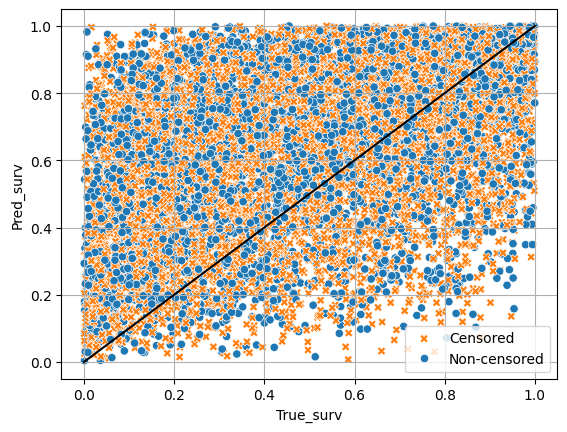

-0.1845

In [17]:
sns.scatterplot(SURV_rsf, x='True_surv', y='Pred_surv', hue='c_y', style='c_y')
sns.lineplot(x=[0,1], y=[0,1], color='black')
plt.legend(['Censored', 'Non-censored'])
plt.grid()
error = abs(SURV_rsf['True_surv'] - SURV_rsf['Pred_surv'])
MSE = np.median(round(error, 4))
print(MSE)
plt.show()
R_sq = 1 - (sum(error**2)/sum((SURV_rsf['True_surv'] - SURV_rsf['True_surv'].mean()) ** 2))
R_sq = round(R_sq, 4)
R_sq

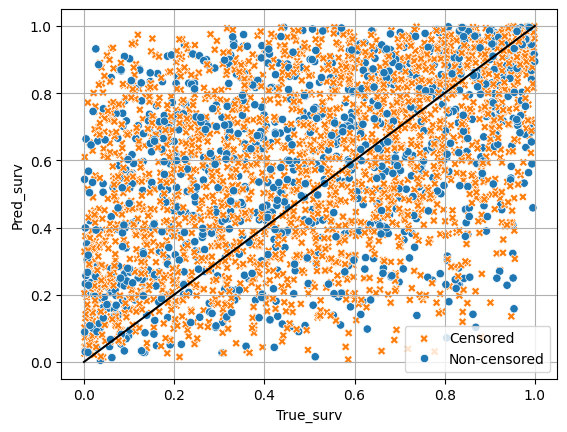

0.194

In [ ]:
sns.scatterplot(SURV_rsf[SURV_rsf['z_y'] == 2], x='True_surv', y='Pred_surv', hue='c_y', style='c_y')
sns.lineplot(x=[0,1], y=[0,1], color='black')
plt.legend(['Censored', 'Non-censored'])
plt.grid()
error = abs(SURV_rsf[SURV_rsf['z_y'] == 2]['True_surv'] - SURV_rsf[SURV_rsf['z_y'] == 2]['Pred_surv'])
MSE = np.median(round(error, 4))
plt.show()
MSE

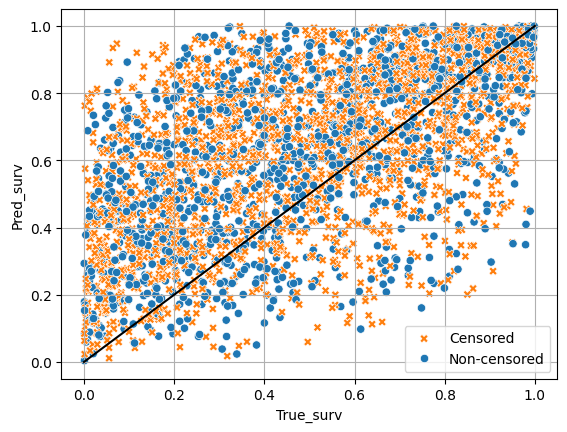

0.178

In [ ]:
sns.scatterplot(SURV_rsf[SURV_rsf['z_y'] == 1], x='True_surv', y='Pred_surv', hue='c_y', style='c_y')
sns.lineplot(x=[0,1], y=[0,1], color='black')
plt.legend(['Censored', 'Non-censored'])
plt.grid()
error = abs(SURV_rsf[SURV_rsf['z_y'] == 1]['True_surv'] - SURV_rsf[SURV_rsf['z_y'] == 1]['Pred_surv'])
MSE = np.median(round(error, 4))
plt.show()
MSE

## Random forest

In [12]:
est = []
RF = RandomSurvivalForest(random_state=555, oob_score=True)
clf = model_selection.RandomizedSearchCV(
    RF,
    param_distributions={'n_estimators': [30, 50, 75, 100, 150, 200],
                         'max_depth': [None, 3, 5, 7, 10, 15, 20, 50],
                         'min_samples_split': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
                         'min_samples_leaf': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
                         'max_leaf_nodes': [None, 10, 15, 20, 30, 50, 75, 100],
                         'max_samples': [0.05, 0.1, 0.2, 0.5, 0.75, 1]},
    scoring={'concordance index': concordance_index_censored}, refit='concordance index', return_train_score=True, n_jobs=4,
    n_iter=1000, random_state=555)
clf.fit(X_train, y_train1)
RFtable = pd.DataFrame(clf.cv_results_)
RFtable.to_csv('''randomrandomforesttable.csv''')
# print('''Best Parameter:\n''', clf.best_params_)
est.append(clf.best_estimator_)
print('''Best model:\n''', clf.best_estimator_)

KeyboardInterrupt: 

In [ ]:
est = RandomSurvivalForest(max_leaf_nodes=15, max_samples=0.75,
                     min_samples_leaf=0.0005, min_samples_split=0.1,
                     n_estimators=30, oob_score=True, random_state=555)

In [26]:
X_test = pd.read_csv('X_test_original.csv', index_col=0)
X_train = pd.read_csv('X_train_original.csv', index_col=0)
y_test = pd.read_csv('y_test_v1.csv', index_col=0)
y_train = pd.read_csv('y_train_v1.csv', index_col=0)
y_train1 = Surv.from_arrays(y_train['event'], y_train['time_to_event'])
y_test1 = Surv.from_arrays(y_test['event'], y_test['time_to_event'])

In [30]:
Cph = CoxPHSurvivalAnalysis()
est_cox = Cph.fit(X_train, y_train1)
survs_test = est_cox.predict_survival_function(X_test)
survs_train = est_cox.predict_survival_function(X_train)
pred_train = est_cox.predict(X_train)
pred_test = est_cox.predict(X_test)
cumu_h_train = est_cox.predict_cumulative_hazard_function(X_train, return_array=True)
cumu_h_test = est_cox.predict_cumulative_hazard_function(X_test, return_array=True)
XX = est_cox.unique_times_
rec = []

for i in [1, 3, 5, 10, 15, 20]:
    print(i)
    preds_test = np.array([fn(365*i) for fn in survs_test])
    print(preds_test)
    preds_test[preds_test == np.inf] = 0
    preds_train = np.array([fn(365*i) for fn in survs_train])
    print(preds_train)
    preds_train[preds_train == np.inf] = 0
    auroc_train = cumulative_dynamic_auc(y_train1, y_train1, pred_train, i*365)
    auroc_test = cumulative_dynamic_auc(y_train1, y_test1, pred_test, i*365)
#    times, score = brier_score(y_train1, y_test1, preds_test, 365*i)
    y_train_true = y_train
    y_train_true['score'] = preds_train
    y_test_true = y_test
    y_test_true['score'] = preds_test
    y_true_train = y_train_true[((y_train_true['time_to_event'] <= i*365) & (y_train_true['event'] == 1))|(y_train_true['event'] == 0) & (y_train_true['time_to_event'] >= i*365)]
    y_true_test = y_test_true[
        ((y_test_true['time_to_event'] <= i * 365) & (y_test_true['event'] == 1)) | (y_test_true['event'] == 0) & (
                    y_test_true['time_to_event'] >= i * 365)]
    precision_train, recall_train, thresholds_train = metrics.precision_recall_curve(y_true_train['event'], y_true_train['score'])
    precision_test, recall_test, thresholds_test = metrics.precision_recall_curve(y_true_test['event'],
                                                                                     y_true_test['score'])
    prc_train = pd.DataFrame({'precision_train': precision_train, 'recall_train': recall_train})
    prc_test = pd.DataFrame({'precision_test': precision_test, 'recall_test': recall_test})
    prc_train.sort_values(by='precision_train', inplace=True)
    prc_test.sort_values(by='precision_test', inplace=True)
    auprc_train = metrics.auc(recall_train, precision_train)
    auprc_test = metrics.auc(recall_test, precision_test)
    # y_train_true = (y_train['time_to_event'] > 365*i)
    # y_test_true = (y_test['time_to_event'] > 365*i)
    # fprtrain, tprtrain, threstrain = metrics.roc_curve(y_train_true, preds_train)
    # fprtest, tprtest, threstest = metrics.roc_curve(y_test_true, preds_test)
    # auroc_train = metrics.auc(fprtrain, tprtrain)
    # auroc_test = metrics.auc(fprtest, tprtest)
    # f1_train = metrics.f1_score(y_train_true, preds_train)
    # f1_test = metrics.f1_score(y_test_true, preds_test)
    rec.append([i, auroc_train[0], auroc_test[0], auprc_train, auprc_test])
brier = pd.DataFrame(rec, columns=['year', 'auroc_train', 'auroc_test', 'auprc_train', 'auprc_test'])
print('Brier Score: \n', brier)
C_index_test = est_cox.score(X_test, y_test1)
C_index_train = est_cox.score(X_train, y_train1)
print('Concordance Index:', C_index_train, C_index_test)

c:\Users\ndong\AppData\Local\Programs\Python\Python39\lib\site-packages\sksurv\linear_model\coxph.py:83: RuntimeWarning: overflow encountered in exp
  self.baseline_survival_ = StepFunction(uniq_times, np.exp(-y))


1
[0.32224673 0.99023812 1.         ... 0.98912488 0.98799182 0.34019659]
[1.         0.01385131 0.99443078 ... 0.99054531 0.98745396 0.98748752]
3
[2.38063162e-04 9.30278062e-01 1.00000000e+00 ... 9.22600669e-01
 9.14842845e-01 3.54918236e-04]
[1.00000000e+00 2.03170942e-14 9.59690345e-01 ... 9.32406273e-01
 9.11180020e-01 9.11408197e-01]
5
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
10
[inf inf inf ... inf inf inf]
[inf inf inf ... inf inf inf]
15
[inf inf inf ... inf inf inf]
[inf inf inf ... inf inf inf]
20
[inf inf inf ... inf inf inf]
[inf inf inf ... inf inf inf]
Brier Score: 
    year           auroc_train            auroc_test  auprc_train  auprc_test
0     1  [0.9925648229458779]  [0.9939594509388249]     0.294348    0.284218
1     3  [0.9951217166723634]  [0.9954867484908434]     0.373371    0.360258
2     5  [0.9907378655747836]  [0.9908189270918132]     0.893916    0.885103
3    10  [0.9859872587323856]  [0.9735009252470445]     0.921892    0.916296
4    15  [0.8554422

In [3]:
Cph = CoxPHSurvivalAnalysis()
est_cox = Cph.fit(X_train, y_train1)
cox_surv = est_cox.predict_survival_function(X_train, return_array=True).mean(axis=0)
COX = pd.DataFrame({'y': est_cox.unique_times_, 'surv_cox': cox_surv})
COX = COX.sort_values(by='y', ascending=False)
est_rf = RandomSurvivalForest(max_leaf_nodes=15, max_samples=0.75, min_samples_leaf=0.0005, min_samples_split=0.1, n_estimators=30, oob_score=True, random_state=200).fit(X_train, y_train1)
rf_surv = est_rf.predict_survival_function(X_train, return_array=True).mean(axis=0)
RF = pd.DataFrame({'y': est_rf.unique_times_, 'surv_cox': rf_surv})
RF = RF.sort_values(by='y', ascending=False)

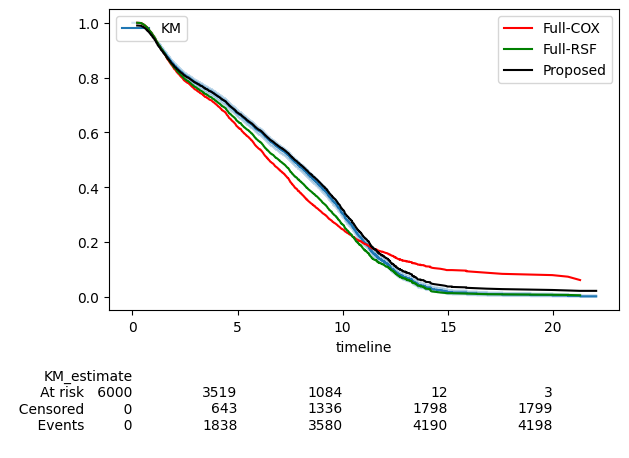

In [4]:
y = pd.concat([y_test, y_train])
y_full = y.copy()
y = Surv.from_arrays(y_full['event'], y_full['time_to_event'])
KMest = KaplanMeierFitter().fit(event_observed=y_full['event'], durations=y_full['time_to_event']/365)
KM_surv = KMest.survival_function_
ax = KMest.plot_survival_function(at_risk_counts=True, label='KM')
ax.legend(loc='upper left')
x_km, y_km, conf_int_km = kaplan_meier_estimator(y['event'], y['time'], conf_type="log-log")
plt.plot(COX['y']/365, COX['surv_cox'], label='Full-COX', color='red')
plt.plot(RF['y']/365, RF['surv_cox'], label='Full-RSF', color='green')
Survival = pd.read_csv('Proposed Survival.csv')
plt.plot(Survival['time_to_event'], Survival['Prop Survival'], label='Proposed', color='black')
plt.legend()


In [19]:
Survival = pd.read_csv('Proposed Survival.csv')
KM_unique_time = KM_surv.loc[COX['y']/365,]
Survival['time_to_event'] = Survival['time_to_event'].round(4)
Survival.set_index('time_to_event', inplace=True)
print(KM_unique_time.shape, COX['surv_cox'].shape)
print(abs(COX['surv_cox'].values - KM_unique_time['KM_estimate'].values).mean())
print(abs(RF['surv_cox'].values - KM_unique_time['KM_estimate'].values).mean())
ind = KM_unique_time.index.values
print(ind.shape)
df3 = Survival.loc[ind,]
df3 = df3[~df3.index.duplicated(keep='first')]
KM = KM_unique_time[~KM_unique_time.index.duplicated(keep='first')]
print(df3.shape, KM.shape)
print(abs(df3.values - KM['KM_estimate'].values).mean())

(4800, 1) (4800,)
0.04476417908782621
0.02713609651511878
(4800,)


KeyError: "None of [Float64Index([ 21.287013003795433,  20.711388208179347,  19.966032563081473,\n                17.58179090886293,   16.85947305864949,   16.36250096339012,\n               15.879561060492492,  15.875935521883575,  15.193563392305144,\n                14.94208974823238,\n              ...\n               0.3838573838319096, 0.35991707848979676,  0.3582634741880465,\n              0.35538176991236803, 0.34461814753361425, 0.33964158139456274,\n               0.3139370628729349,  0.2696486682451871,  0.2383758416374619,\n              0.22839255719831944],\n             dtype='float64', name='time_to_event', length=4800)] are in the [index]"

In [21]:
Cph = CoxPHSurvivalAnalysis()
est_cox = Cph.fit(X_train, y_train1)
cox_surv = est_cox.predict_survival_function(X_test, return_array=True).mean(axis=0)
COX = pd.DataFrame({'y': est_cox.unique_times_, 'surv_cox': cox_surv})
COX = COX.sort_values(by='y', ascending=False)
est_rf = RandomSurvivalForest(max_leaf_nodes=15, max_samples=0.75, min_samples_leaf=0.0005, min_samples_split=0.1, n_estimators=30, oob_score=True, random_state=200).fit(X_train, y_train1)
rf_surv = est_rf.predict_survival_function(X_test, return_array=True).mean(axis=0)
RF = pd.DataFrame({'y': est_rf.unique_times_, 'surv_cox': rf_surv})
RF = RF.sort_values(by='y', ascending=False)

KM_unique_time_test = KM_surv.loc[COX['y']/365,]
Survival = pd.read_csv('Proposed Survival.csv')
Survival['time_to_event'] = Survival['time_to_event'].round(4)
Survival.set_index('time_to_event', inplace=True)
print(KM_unique_time.shape, COX['surv_cox'].shape)
print(abs(COX['surv_cox'].values - KM_unique_time['KM_estimate'].values).mean())
print(abs(RF['surv_cox'].values - KM_unique_time['KM_estimate'].values).mean())
ind = ((COX['y']/365).round(4)).values
print(abs(Survival.loc[ind, 'Prop Survival'].values - KM_unique_time['KM_estimate'].values).mean())

(4800, 1) (4800,)
0.03697791798694691
0.01842399356959188


ValueError: operands could not be broadcast together with shapes (5109,) (4800,) 

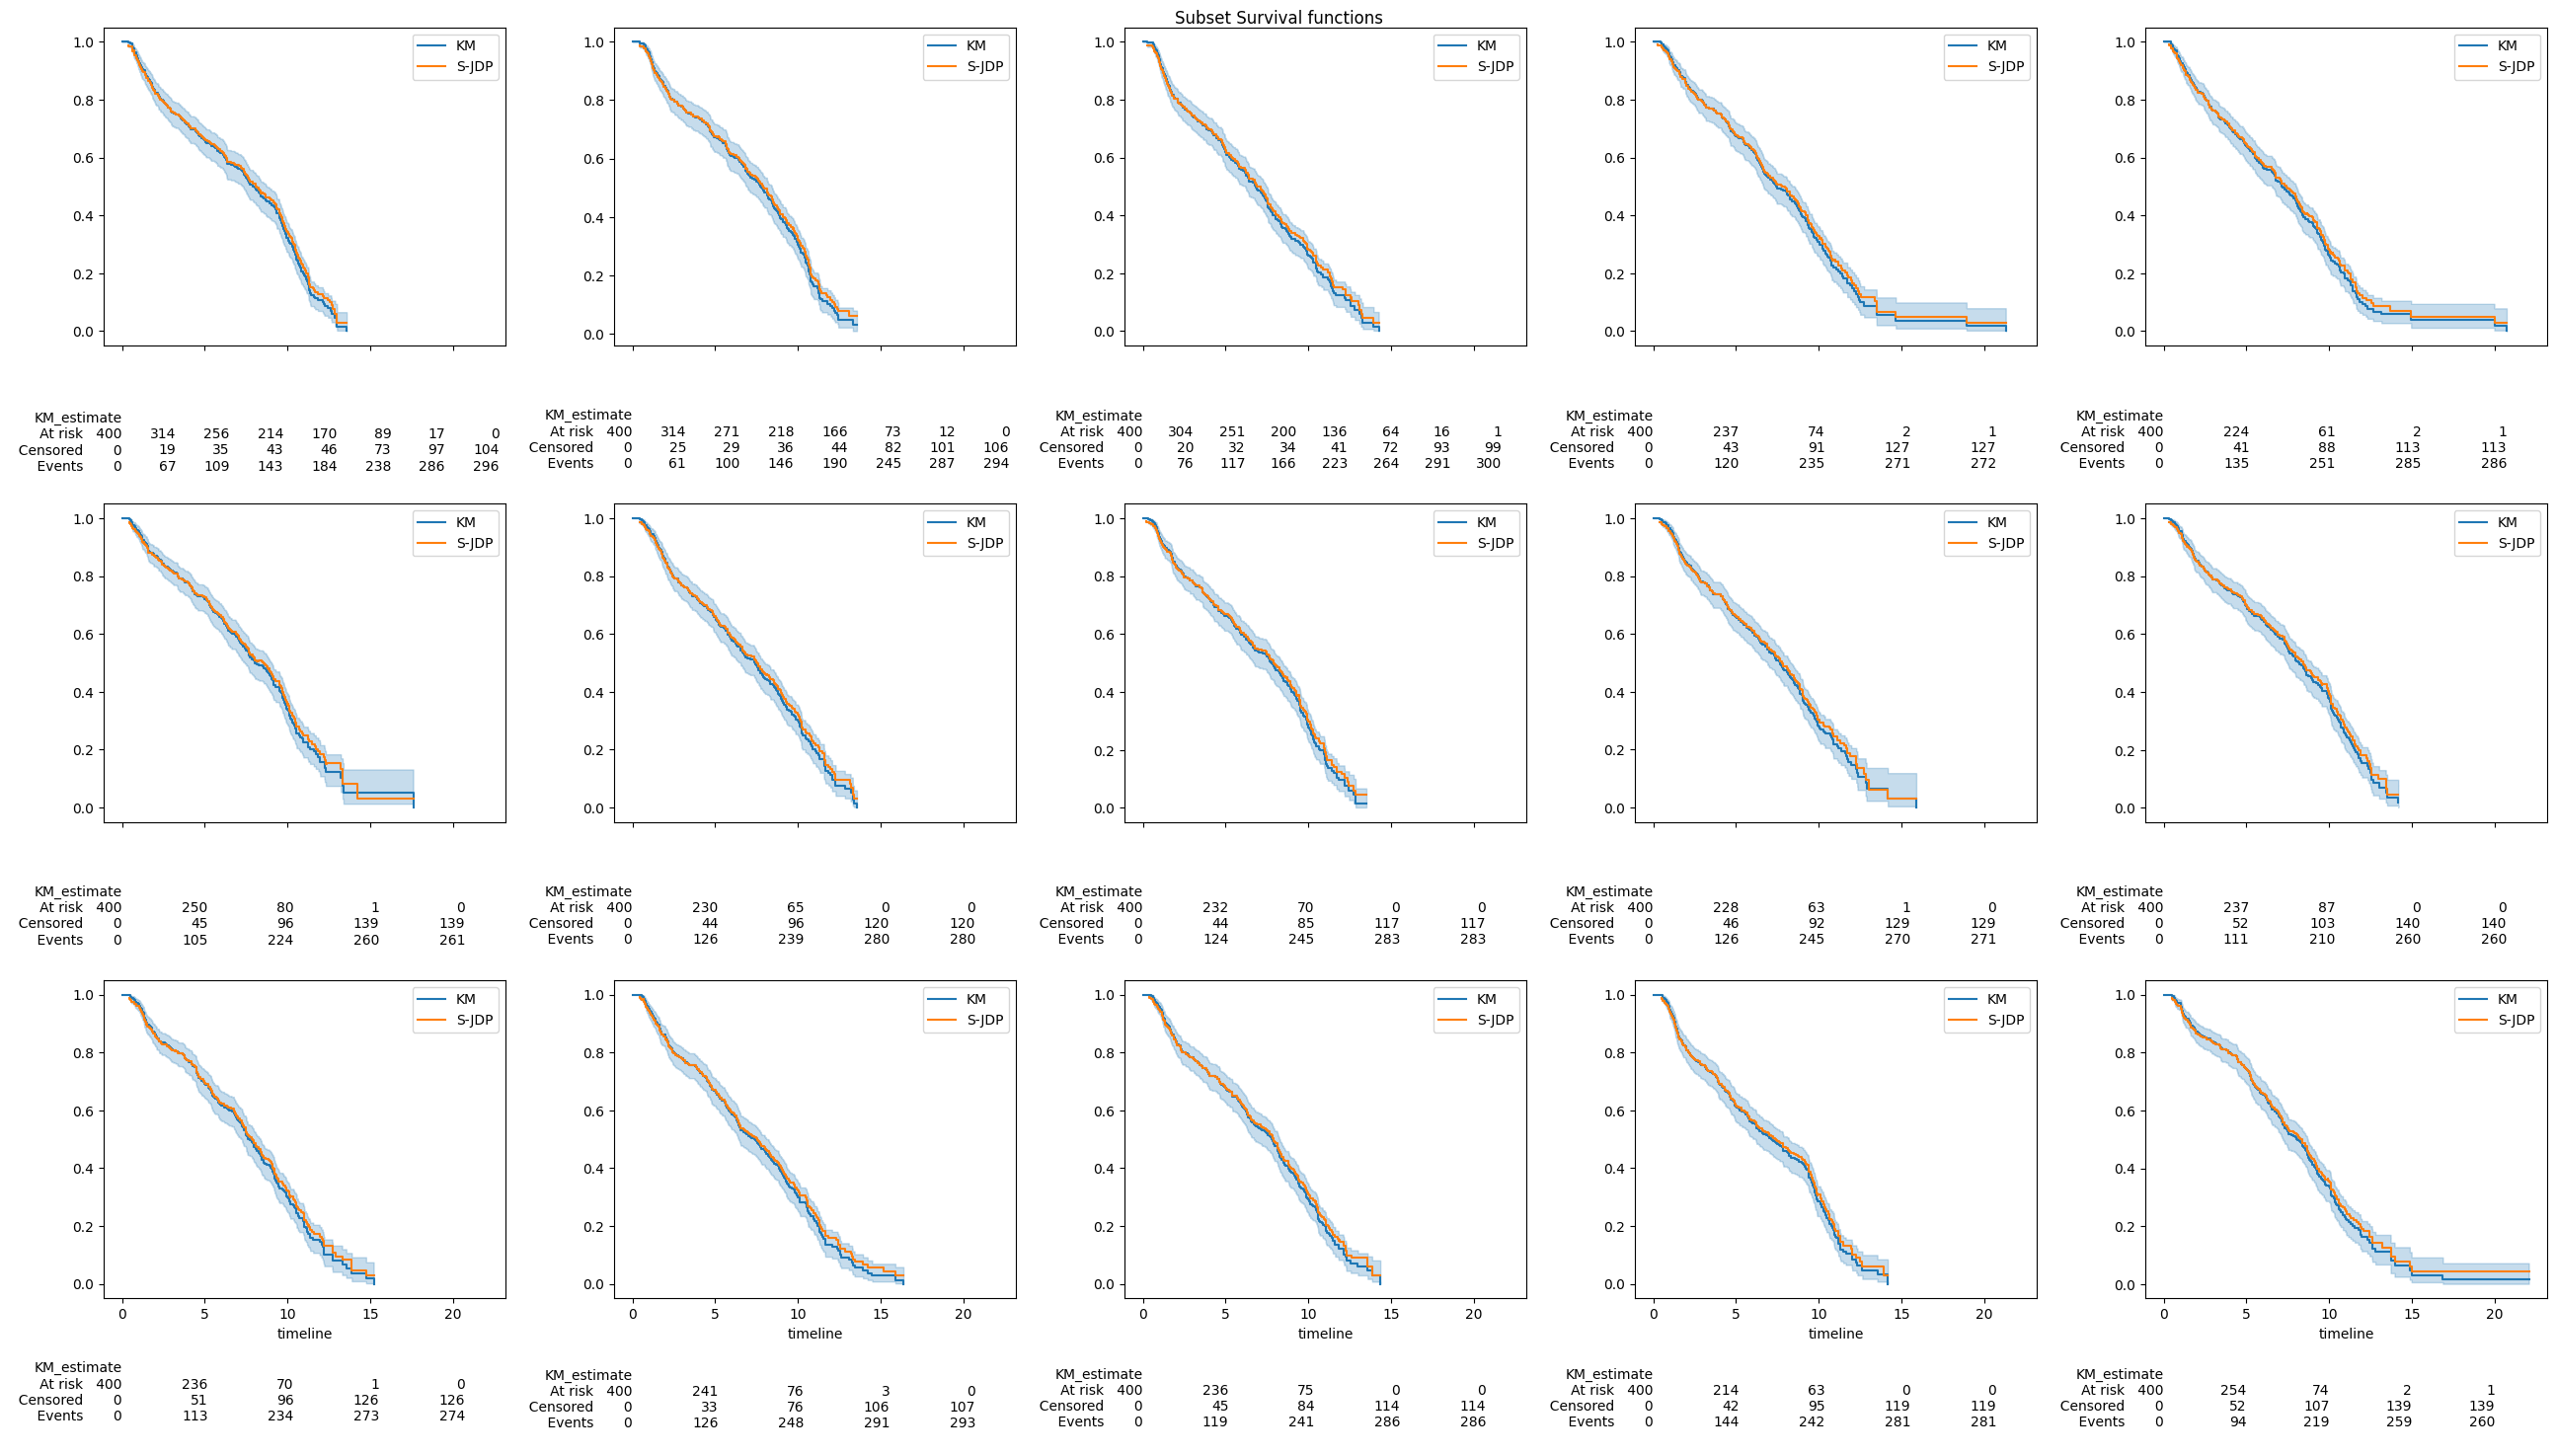

In [46]:
fig, axes = plt.subplots(3, 5, sharex=True, figsize=(26,15))
fig.suptitle('Subset Survival functions')
for i in range(3):
    for j in range(5):
        dat = pd.read_csv(f'simulation subset{i*5+j+1}.csv')
        KMest = KaplanMeierFitter().fit(event_observed=dat['event'], durations=dat['time_to_event']/365)
        y = Surv.from_arrays(dat['event'], dat['time_to_event'])
        x_km, y_km, conf_int_km = kaplan_meier_estimator(y['event'], y['time'], conf_type="log-log")
        y_dp = pd.read_csv(f"Subset{i*5+j+1}_dp_results.csv")
        KMest.plot_survival_function(ax=axes[i,j], at_risk_counts=True, label='KM')
        axes[i,j].step(y_dp['time'], y_dp['survival_f'], label='S-JDP')
        axes[i,j].legend()

In [40]:
dat = pd.read_csv('full_data_simulation_1_v3.csv')
dat = dat.sample(frac=1, random_state=555)
k = np.array_split(dat, 15)
k = [k[i].to_csv(f'simulation subset{i+1}.csv') for i in range(15)]